In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline

In [208]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [209]:
!wget $data

--2025-10-13 20:24:20--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.4’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.002s  

2025-10-13 20:24:20 (32.4 MB/s) - ‘course_lead_scoring.csv.4’ saved [80876/80876]



In [210]:
df = pd.read_csv('course_lead_scoring.csv')

In [211]:
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [213]:
df['converted'] = df['converted'].map({0: 'No', 1: 'Yes'}).astype('object')

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 102.9+ KB


In [215]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [216]:
for col in df.columns:
    if df[col].dtype == 'object':  # categorical feature
        df[col] = df[col].fillna('NA')
    else:  # numerical feature
        df[col] = df[col].fillna(0.0)

In [217]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [218]:
most_frequent_industry = df['industry'].mode()[0]
print("Most frequent industry:", most_frequent_industry)

Most frequent industry: retail


In [219]:
freq = df['industry'].value_counts().iloc[0]
print(f"'{most_frequent_industry}' appears {freq} times.")

'retail' appears 203 times.


In [220]:
# select only numerical features
num_df = df.select_dtypes(include=['number'])

# compute the correlation matrix
corr_matrix = num_df.corr()

# display the matrix
print("Correlation matrix:")
print(corr_matrix)

Correlation matrix:
                          number_of_courses_viewed  annual_income  \
number_of_courses_viewed                  1.000000       0.009770   
annual_income                             0.009770       1.000000   
interaction_count                        -0.023565       0.027036   
lead_score                               -0.004879       0.015610   

                          interaction_count  lead_score  
number_of_courses_viewed          -0.023565   -0.004879  
annual_income                      0.027036    0.015610  
interaction_count                  1.000000    0.009888  
lead_score                         0.009888    1.000000  


In [221]:
# find the two features with the highest correlation (excluding self-correlation)
corr_unstacked = corr_matrix.unstack().sort_values(ascending=False)

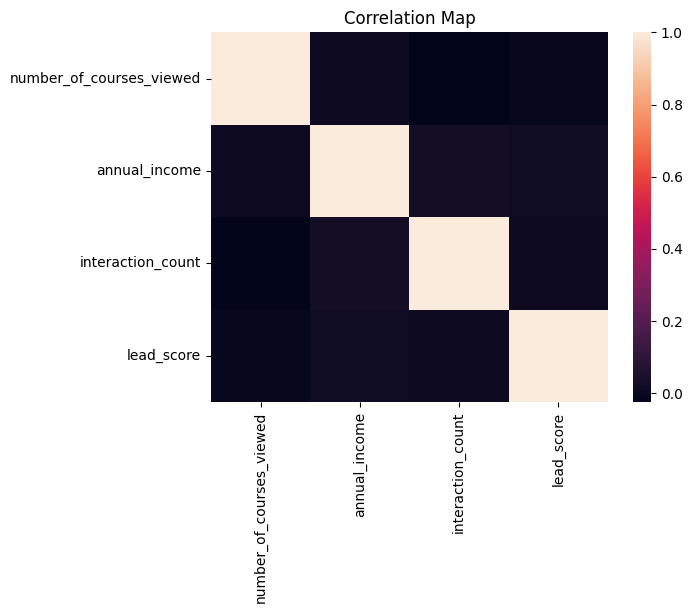

In [222]:
# Correlation map
plt.title("Correlation Map") # map title
sns.heatmap(corr_matrix);

In [223]:
# remove self-correlations (correlation of a variable with itself = 1)
corr_unstacked = corr_unstacked[corr_unstacked < 1]

# get the pair with the largest correlation
max_corr_pair = corr_unstacked.idxmax()
max_corr_value = corr_unstacked.max()

print(f"\nThe two features with the biggest correlation are {max_corr_pair[0]} and {max_corr_pair[1]} (correlation = {max_corr_value:.3f})")


The two features with the biggest correlation are annual_income and interaction_count (correlation = 0.027)


In [224]:
# Separate features (X) and target (y)
X = df.drop('converted', axis=1)  # remove target column
y = df['converted']               # target column

# Splitting into full train and test
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)

# Splitting into train and validation
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 42)

# check sizes
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [225]:
df_train

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
1077,paid_ads,retail,0,58472.0,student,middle_east,5,0.03,No
463,organic_search,manufacturing,3,71738.0,student,middle_east,6,0.77,Yes
842,paid_ads,technology,3,81973.0,employed,north_america,2,0.59,Yes
835,NA,technology,1,74956.0,employed,europe,3,0.34,Yes
837,organic_search,retail,3,59335.0,student,australia,1,0.98,Yes
...,...,...,...,...,...,...,...,...,...
725,organic_search,other,1,43907.0,employed,australia,4,0.33,Yes
401,social_media,retail,3,64969.0,employed,north_america,1,0.18,No
957,NA,education,3,89042.0,employed,asia,4,0.75,Yes
992,social_media,manufacturing,1,0.0,self_employed,europe,1,0.65,No


In [226]:
# Separate target from each dataset
y_train = df_train['converted']
y_val = df_val['converted']
y_test = df_test['converted']

# Drop target column from feature sets
X_train = df_train.drop('converted', axis=1)
X_val = df_val.drop('converted', axis=1)
X_test = df_test.drop('converted', axis=1)

In [227]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 876 entries, 1077 to 1267
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               876 non-null    object 
 1   industry                  876 non-null    object 
 2   number_of_courses_viewed  876 non-null    int64  
 3   annual_income             876 non-null    float64
 4   employment_status         876 non-null    object 
 5   location                  876 non-null    object 
 6   interaction_count         876 non-null    int64  
 7   lead_score                876 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 61.6+ KB


In [228]:
# Function to get mutual information sore with respect to the churn
def mutual_info_y_score(series):
    """
    This function takes a series and returns the mutual information score
    with respect to the `y` variable of the train set.
    """
    return mutual_info_score(series, y_train)

In [229]:
# Apply mutual information columnwise to categorical variables
mi_scores = df_train.select_dtypes("object").apply(mutual_info_y_score)

# Sourt scores in ascending order
mi_scores.sort_values(ascending = False)

converted            0.661854
lead_source          0.035396
employment_status    0.012938
industry             0.011575
location             0.004464
dtype: float64

In [230]:
# 1️⃣ Identify categorical and numerical features
cat_features = X_train.select_dtypes(include=['object', 'category']).columns
num_features = X_train.select_dtypes(exclude=['object', 'category']).columns

# 2️⃣ Build a preprocessing pipeline (One-Hot Encode categorical features)
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='passthrough')  # leave numeric columns as they are

# 3️⃣ Define the logistic regression model
model = LogisticRegression(
    solver='liblinear',
    C=1.0,
    max_iter=1000,
    random_state=42
)

# 4️⃣ Combine preprocessing + model in a single pipeline
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# 5️⃣ Fit the model on training data
clf.fit(X_train, y_train)

# 6️⃣ Predict on validation data
y_pred = clf.predict(X_val)

# 7️⃣ Calculate accuracy
val_accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", round(val_accuracy, 3))

Validation Accuracy: 0.7


In [231]:
# Convert 'converted' column in all splits back to numeric (0/1)
df_train['converted'] = df_train['converted'].map({'No': 0, 'Yes': 1}).astype(int)
df_val['converted']   = df_val['converted'].map({'No': 0, 'Yes': 1}).astype(int)
df_test['converted']  = df_test['converted'].map({'No': 0, 'Yes': 1}).astype(int)

# Verify
print(df_train['converted'].dtype)
print(df_train['converted'].value_counts())

int64
converted
1    547
0    329
Name: count, dtype: int64


In [232]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 876 entries, 1077 to 1267
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               876 non-null    object 
 1   industry                  876 non-null    object 
 2   number_of_courses_viewed  876 non-null    int64  
 3   annual_income             876 non-null    float64
 4   employment_status         876 non-null    object 
 5   location                  876 non-null    object 
 6   interaction_count         876 non-null    int64  
 7   lead_score                876 non-null    float64
 8   converted                 876 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 68.4+ KB


In [233]:
# Initialize vectorizer
One_Hot_encoder = DictVectorizer(sparse = False) # sparse when there are many categorical variables ---> most of them are 0s

# Convert training set to a dictionary
train_dict = df_train.to_dict(orient = 'records')

# Train the vectorizer and transform features
X_train = One_Hot_encoder.fit_transform(train_dict)

In [234]:
# Check the features
One_Hot_encoder.get_feature_names_out()

array(['annual_income', 'converted', 'employment_status=NA',
       'employment_status=employed', 'employment_status=self_employed',
       'employment_status=student', 'employment_status=unemployed',
       'industry=NA', 'industry=education', 'industry=finance',
       'industry=healthcare', 'industry=manufacturing', 'industry=other',
       'industry=retail', 'industry=technology', 'interaction_count',
       'lead_score', 'lead_source=NA', 'lead_source=events',
       'lead_source=organic_search', 'lead_source=paid_ads',
       'lead_source=referral', 'lead_source=social_media', 'location=NA',
       'location=africa', 'location=asia', 'location=australia',
       'location=europe', 'location=middle_east',
       'location=north_america', 'location=south_america',
       'number_of_courses_viewed'], dtype=object)

In [235]:
# Define the model
model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000, random_state = 42)

# Model fitting
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [236]:
# Convert validation set to a dictionary
val_dict = df_val.to_dict(orient = 'records')

# Transform validation data
X_val = One_Hot_encoder.transform(val_dict)
# Make predictions
y_pred = model.predict(X_val)

# Accuracy score
accuracy = (y_pred == y_val).mean()
round(accuracy, 2)

np.float64(0.76)

In [237]:
X_train = df_train.drop('converted', axis=1)
y_train = df_train['converted']

X_val = df_val.drop('converted', axis=1)
y_val = df_val['converted']

In [238]:

# 1️⃣ Identify categorical and numerical features
cat_features = X_train.select_dtypes(include=['object', 'category']).columns
num_features = X_train.select_dtypes(exclude=['object', 'category']).columns

# 2️⃣ Build preprocessing and model pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='passthrough')

model = LogisticRegression(
    solver='liblinear',
    C=1.0,
    max_iter=1000,
    random_state=42
)

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# 3️⃣ Train the full model (with all features)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
base_accuracy = accuracy_score(y_val, y_pred)
print(f"Base accuracy: {base_accuracy:.4f}")

# 4️⃣ Test each feature by removing it and retraining
feature_impact = {}

for feature in X_train.columns:
    # drop the feature
    X_train_reduced = X_train.drop(columns=[feature])
    X_val_reduced = X_val.drop(columns=[feature])
    
    # redefine which features are categorical/numerical for the reduced set
    cat_reduced = X_train_reduced.select_dtypes(include=['object', 'category']).columns
    
    preprocessor_reduced = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_reduced)
    ], remainder='passthrough')
    
    clf_reduced = Pipeline([
        ('preprocessor', preprocessor_reduced),
        ('model', model)
    ])
    
    # train & evaluate
    clf_reduced.fit(X_train_reduced, y_train)
    y_pred_reduced = clf_reduced.predict(X_val_reduced)
    acc_reduced = accuracy_score(y_val, y_pred_reduced)
    
    # store accuracy difference
    feature_impact[feature] = base_accuracy - acc_reduced

# 5️⃣ Show differences
impact_df = pd.Series(feature_impact).sort_values(ascending=True)
print("\nAccuracy drop when removing each feature:")
print(impact_df)

Base accuracy: 0.6997

Accuracy drop when removing each feature:
annual_income              -0.153584
location                   -0.010239
lead_score                 -0.006826
lead_source                -0.003413
industry                    0.000000
employment_status           0.003413
number_of_courses_viewed    0.143345
interaction_count           0.143345
dtype: float64


In [239]:
# Identify categorical and numerical features
cat_features = X_train.select_dtypes(include=['object', 'category']).columns

# Preprocessor: one-hot encode categorical variables
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='passthrough')

# List of C values to test
C_values = [0.01, 0.1, 1, 10, 100]
accuracies = {}

for c in C_values:
    model = LogisticRegression(
        solver='liblinear',
        C=c,
        max_iter=1000,
        random_state=42
    )

    clf = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train model
    clf.fit(X_train, y_train)
    
    # Predict on validation data
    y_pred = clf.predict(X_val)
    
    # Compute accuracy
    acc = accuracy_score(y_val, y_pred)
    accuracies[c] = round(acc, 3)

# Display results
print("Validation accuracy for each C value:")
for c, acc in accuracies.items():
    print(f"C={c}: accuracy={acc}")

best_c = max(accuracies, key=accuracies.get)
print(f"\nBest C: {best_c} (accuracy={accuracies[best_c]})")

Validation accuracy for each C value:
C=0.01: accuracy=0.7
C=0.1: accuracy=0.7
C=1: accuracy=0.7
C=10: accuracy=0.7
C=100: accuracy=0.7

Best C: 0.01 (accuracy=0.7)
